# **Pirate Pain Challenge - Data Visualization**

## 🌐 **Google Drive Connection or local mount**

In [31]:
import os

isColab = False

try:
    from google.colab import drive

    drive.mount("/gdrive")
    current_dir = "/gdrive/My\\ Drive/Colab\\ Notebooks/[2025-2026]\\ AN2DL/AN2DL-challenge-1"
    print("Running in Google Colab. Google Drive mounted.")
    %cd $current_dir
    isColab = True
except ImportError:
    print("Running in a local environment. Skipping Google Drive mount.")
    current_dir = r"G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-1"
    if not os.path.isdir(current_dir):
        current_dir = os.getcwd()
    print(f"Current directory set to: {current_dir}")
if not isColab:
    os.chdir(current_dir)
print(f"Changed directory to: {current_dir}")

Running in a local environment. Skipping Google Drive mount.
Current directory set to: G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-1
Changed directory to: G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-1


## ⚙️ **Libraries Import**

In [32]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch

torch.manual_seed(SEED)
# from torchsummary import summary

logs_dir = "tensorboard"
if isColab:
    !pkill -f tensorboard
else:
    # Arresta eventuali processi tensorboard in locale (Windows)
    import os
    if os.name == 'nt':
        try:
            import psutil
            for proc in psutil.process_iter(['name', 'cmdline']):
                name = (proc.info.get('name') or '').lower()
                cmd = ' '.join(proc.info.get('cmdline') or []).lower()
                if 'tensorboard' in name or 'tensorboard' in cmd:
                    try:
                        proc.kill()
                    except Exception:
                        pass
        except ImportError:
            import subprocess
            subprocess.run(['taskkill', '/F', '/IM', 'tensorboard.exe'],
                           stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

%load_ext tensorboard
if isColab:
    !mkdir -p models
else:
    os.makedirs("models", exist_ok=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.9.0+cu130
Device: cuda


## ⏳ **Data Downloading**

In [33]:
import os
import zipfile

# --- 1. Impostazioni ---
competition_name = 'an2dl2526c1'
dataset_path = 'dataset'
train_file = 'pirate_pain_train.csv'
test_file = 'pirate_pain_test.csv'
labels_file = 'pirate_pain_train_labels.csv'
sample_submission_file = 'sample_submission.csv'

# Controlla se il dataset è già stato scaricato ed estratto
if not os.path.exists(os.path.join(dataset_path, train_file)):
    # --- 2. Autenticazione e Download ---
    from kaggle.api.kaggle_api_extended import KaggleApi
    # Inizializza l'API di Kaggle
    # L'autenticazione avviene automaticamente se 'kaggle.json' è in C:\\Users\\Bert0ns\\.kaggle\\
    api = KaggleApi()
    api.authenticate()

    print(f"Download del dataset dalla competizione '{competition_name}'...")

    # Crea la directory di destinazione se non esiste
    os.makedirs(dataset_path, exist_ok=True)

    # Scarica i file della competizione nella cartella 'dataset'
    api.competition_download_files(competition_name, path=dataset_path)

    # Estrai i file dall'archivio zip
    zip_path = os.path.join(dataset_path, f'{competition_name}.zip')
    if os.path.exists(zip_path):
        print(f"Estrazione dei file da '{zip_path}'...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(dataset_path)
        # Rimuovi il file zip dopo l'estrazione
        os.remove(zip_path)
        print("Estrazione completata e file zip rimosso.")
    else:
        print("ATTENZIONE: File zip non trovato. Il download potrebbe non essere riuscito.")
else:
    print("Il dataset è già presente nella cartella 'dataset'. Download saltato.")


Il dataset è già presente nella cartella 'dataset'. Download saltato.


## 🔎 **Exploration and Data Analysis**

In [34]:
import pandas as pd

# Load the datasets
train_df = pd.read_csv(os.path.join(dataset_path, train_file))
kaggle_test_df = pd.read_csv(os.path.join(dataset_path, test_file))
labels_df = pd.read_csv(os.path.join(dataset_path, labels_file))
sample_submission_df = pd.read_csv(os.path.join(dataset_path, sample_submission_file))

In [35]:
print(f"DataFrame shape: {train_df.shape}")
train_df.head(300)

DataFrame shape: (105760, 40)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,3.999558e-06,1.153299e-05,3.805930e-06,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765107e-07,6.019627e-06,4.643774e-08,0.000000e+00,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,1.446051e-06,2.424536e-06,2.513519e-06,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2,2,2,2,two,two,two,0.938017,...,1.006865e-05,5.511079e-07,1.847597e-06,5.432416e-08,0.000000e+00,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2,2,2,2,two,two,two,1.090185,...,4.437266e-06,1.735459e-07,1.552722e-06,5.825366e-08,7.044832e-06,0.005360,0.002532,0.033026,0.025328,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,1,135,2,2,2,2,two,two,two,1.224606,...,0.000000e+00,1.457226e-06,1.978559e-06,1.933064e-06,6.102752e-06,0.037370,0.071729,0.085482,0.043072,0.5
296,1,136,2,2,2,2,two,two,two,1.224941,...,9.480348e-07,3.483824e-07,2.366589e-06,2.745167e-07,1.134226e-05,0.030967,0.086378,0.090824,0.054885,0.5
297,1,137,2,1,2,2,two,two,two,1.252871,...,3.317316e-07,2.317636e-06,1.235017e-07,4.266181e-07,1.601467e-06,0.015595,0.068413,0.132164,0.073057,0.5
298,1,138,2,2,1,2,two,two,two,1.251569,...,3.093716e-07,3.494299e-07,1.192149e-07,2.709641e-07,9.290970e-07,0.044671,0.119201,0.130871,0.061973,0.5


In [36]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  object 
 7   n_hands        105760 non-null  object 
 8   n_eyes         105760 non-null  object 
 9   joint_00       105760 non-null  float64
 10  joint_01       105760 non-null  float64
 11  joint_02       105760 non-null  float64
 12  joint_03       105760 non-null  float64
 13  joint_04       105760 non-null  float64
 14  joint_05       105760 non-null  float64
 15  joint_06       105760 non-null  float64
 16  joint_07       105760 non-null  float64
 17  joint_08       105760 non-nul

In [37]:
print(f"DataFrame shape: {kaggle_test_df.shape}")
kaggle_test_df.head()

DataFrame shape: (211840, 40)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,2,2,2,two,two,two,0.842535,...,0.000003,0.000004,0.000003,0.000003,0.000068,0.019372,0.066324,0.022228,0.013576,0.5
1,0,1,2,2,2,2,two,two,two,0.898836,...,0.000003,0.000004,0.000004,0.000003,0.000029,0.069747,0.080417,0.023650,0.038793,0.5
2,0,2,2,2,2,2,two,two,two,0.957765,...,0.000006,0.000004,0.000009,0.000004,0.000008,0.054968,0.058811,0.027023,0.054202,0.5
3,0,3,1,2,2,2,two,two,two,0.832596,...,0.000005,0.000004,0.000003,0.000004,0.000015,0.048695,0.047128,0.016151,0.024983,0.5
4,0,4,2,2,2,0,two,two,two,0.805971,...,0.000006,0.000004,0.000003,0.000003,0.000008,0.019762,0.031116,0.015618,0.017931,0.5


In [38]:
kaggle_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211840 entries, 0 to 211839
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   211840 non-null  int64  
 1   time           211840 non-null  int64  
 2   pain_survey_1  211840 non-null  int64  
 3   pain_survey_2  211840 non-null  int64  
 4   pain_survey_3  211840 non-null  int64  
 5   pain_survey_4  211840 non-null  int64  
 6   n_legs         211840 non-null  object 
 7   n_hands        211840 non-null  object 
 8   n_eyes         211840 non-null  object 
 9   joint_00       211840 non-null  float64
 10  joint_01       211840 non-null  float64
 11  joint_02       211840 non-null  float64
 12  joint_03       211840 non-null  float64
 13  joint_04       211840 non-null  float64
 14  joint_05       211840 non-null  float64
 15  joint_06       211840 non-null  float64
 16  joint_07       211840 non-null  float64
 17  joint_08       211840 non-nul

In [39]:
print(f"DataFrame shape: {labels_df.shape}")
labels_df.head()

DataFrame shape: (661, 2)


,sample_index,label
0,0,no_pain
1,1,no_pain
2,2,low_pain
3,3,no_pain
4,4,no_pain


In [40]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 661 entries, 0 to 660
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sample_index  661 non-null    int64 
 1   label         661 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.5+ KB


In [41]:
print(f"DataFrame shape: {sample_submission_df.shape}")
sample_submission_df.head()

DataFrame shape: (1324, 2)


,sample_index,label
0,0,high_pain
1,1,no_pain
2,2,no_pain
3,3,low_pain
4,4,high_pain


In [42]:
sample_submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sample_index  1324 non-null   int64 
 1   label         1324 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.8+ KB


**Convert data to a memory efficient form**

In [43]:
na_value = -1
text_map = {
    'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4,
    '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
    'unknown': na_value, 'nan': na_value, 'none': na_value, 'n/a': na_value,
    'one+peg_leg': 1, 'one+hook_hand': 1, 'one+eye_patch': 1,
    'no_pain': 0, 'low_pain': 1, 'high_pain': 2
}

# Pulisce, normalizza, mappa; fallback a numerico e a cifre estratte
columns_to_convert = ['n_legs', 'n_hands', 'n_eyes']
for col in columns_to_convert:
    train_df[col] = train_df[col].str.strip().str.lower().map(text_map).astype('int8')
    kaggle_test_df[col] = kaggle_test_df[col].str.strip().str.lower().map(text_map).astype('int8')

# train_df.head(105760)

In [44]:
# Convert data types from float64 to float32 to save memory
train_df[train_df.select_dtypes(include=['float64']).columns] = train_df.select_dtypes(include=['float64']).astype(
    'float32')
kaggle_test_df[kaggle_test_df.select_dtypes(include=['float64']).columns] = kaggle_test_df.select_dtypes(
    include=['float64']).astype(
    'float32')

# Convert int64 to int32
train_df[train_df.select_dtypes(include=['int64']).columns] = train_df.select_dtypes(include=['int64']).astype('int32')
kaggle_test_df[kaggle_test_df.select_dtypes(include=['int64']).columns] = kaggle_test_df.select_dtypes(
    include=['int64']).astype('int32')
labels_df[labels_df.select_dtypes(include=['int64']).columns] = labels_df.select_dtypes(include=['int64']).astype(
    'int32')

# Convert pain surveys to int8
train_df['pain_survey_1'] = train_df['pain_survey_1'].astype('int8')
train_df['pain_survey_2'] = train_df['pain_survey_2'].astype('int8')
train_df['pain_survey_3'] = train_df['pain_survey_3'].astype('int8')
train_df['pain_survey_4'] = train_df['pain_survey_4'].astype('int8')

kaggle_test_df['pain_survey_1'] = kaggle_test_df['pain_survey_1'].astype('int8')
kaggle_test_df['pain_survey_2'] = kaggle_test_df['pain_survey_2'].astype('int8')
kaggle_test_df['pain_survey_3'] = kaggle_test_df['pain_survey_3'].astype('int8')
kaggle_test_df['pain_survey_4'] = kaggle_test_df['pain_survey_4'].astype('int8')

# Convert labels sample_index to int8
labels_df['label'] = labels_df['label'].str.strip().str.lower().map(text_map).astype('int8')

In [45]:
print("train:\n")
train_df.info()
print("\nkaggle test:\n")
kaggle_test_df.info()
print("\nlabels:\n")
labels_df.info()

train:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int32  
 1   time           105760 non-null  int32  
 2   pain_survey_1  105760 non-null  int8   
 3   pain_survey_2  105760 non-null  int8   
 4   pain_survey_3  105760 non-null  int8   
 5   pain_survey_4  105760 non-null  int8   
 6   n_legs         105760 non-null  int8   
 7   n_hands        105760 non-null  int8   
 8   n_eyes         105760 non-null  int8   
 9   joint_00       105760 non-null  float32
 10  joint_01       105760 non-null  float32
 11  joint_02       105760 non-null  float32
 12  joint_03       105760 non-null  float32
 13  joint_04       105760 non-null  float32
 14  joint_05       105760 non-null  float32
 15  joint_06       105760 non-null  float32
 16  joint_07       105760 non-null  float32
 17  joint_08       105760

In [46]:
# Visualize count of timestamps per categorical feature
def plot_timestamps_per_feature(df, columns, n_cols=4, figsize_per_plot=(4, 3)):
    n = len(columns)
    n_rows = (n + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize_per_plot[0] * n_cols, figsize_per_plot[1] * n_rows),
                             constrained_layout=True)
    axes = axes.flatten()

    for ax, col in zip(axes, columns):
        series = df[col].dropna()
        # numerical order if possible, else frequency order
        try:
            order = sorted(series.unique())
        except Exception:
            order = series.value_counts().index

        sns.countplot(
            x=col,
            data=df,
            order=order,
            palette='viridis',
            ax=ax
        )
        ax.set_title(f"Number of timestamps: {col.title()}", fontsize=11)
        ax.set_xlabel(col.replace('_', ' ').title(), fontsize=9)
        ax.set_ylabel("Counts", fontsize=9)
        ax.grid(axis='y', alpha=0.25, linestyle='--', linewidth=0.7)

        total = len(df[col])
        ymax = 0
        for p in ax.patches:
            count = int(p.get_height())
            if count > ymax:
                ymax = count
            if count > 0:
                ax.text(
                    p.get_x() + p.get_width() / 2,
                    p.get_height() + total * 0.005,
                    f"{count}\n{count / total:.1%}",
                    ha='center',
                    va='bottom',
                    fontsize=8
                )
        ax.set_ylim(0, ymax * 1.20)

        if len(order) > 8:
            ax.tick_params(axis='x', rotation=35)

    for ax in axes[n:]:
        ax.axis('off')

    plt.show()
    plt.close(fig)

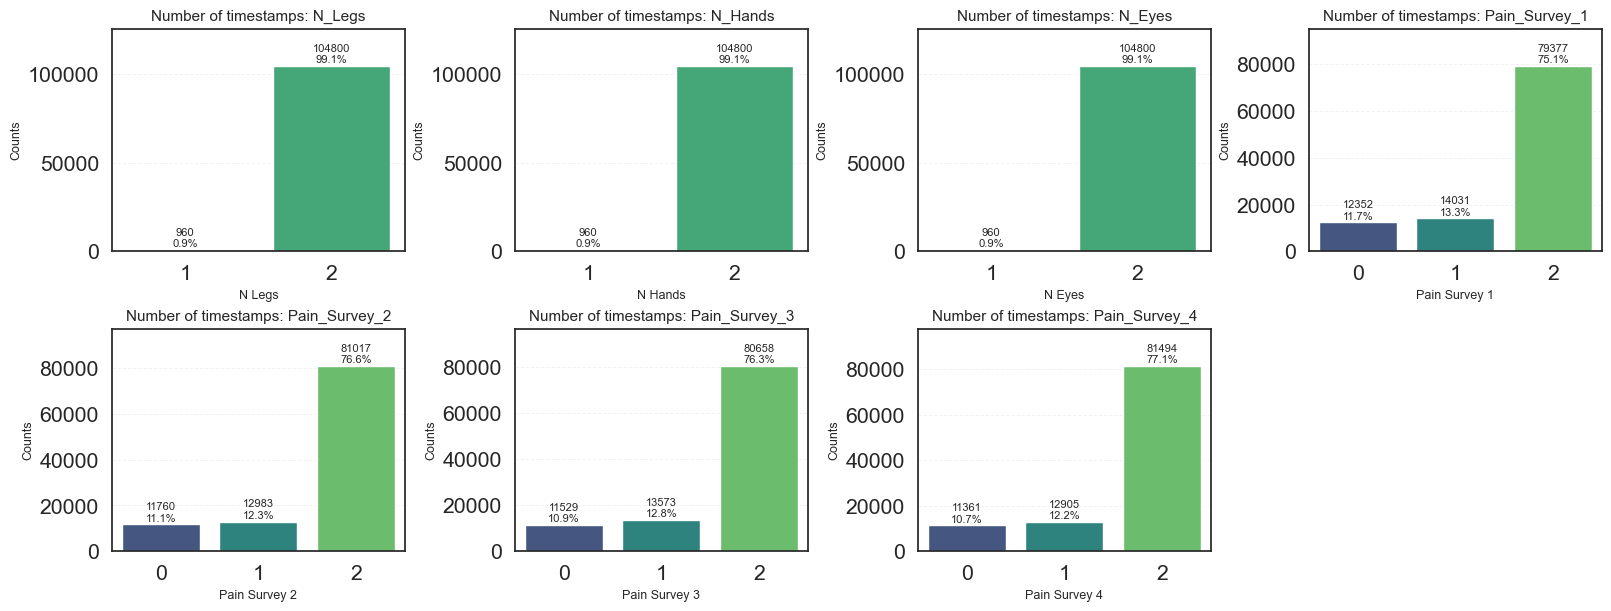

In [47]:
categorical_columns = ['n_legs', 'n_hands', 'n_eyes', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3',
                       'pain_survey_4']
plot_timestamps_per_feature(train_df, categorical_columns, n_cols=4)

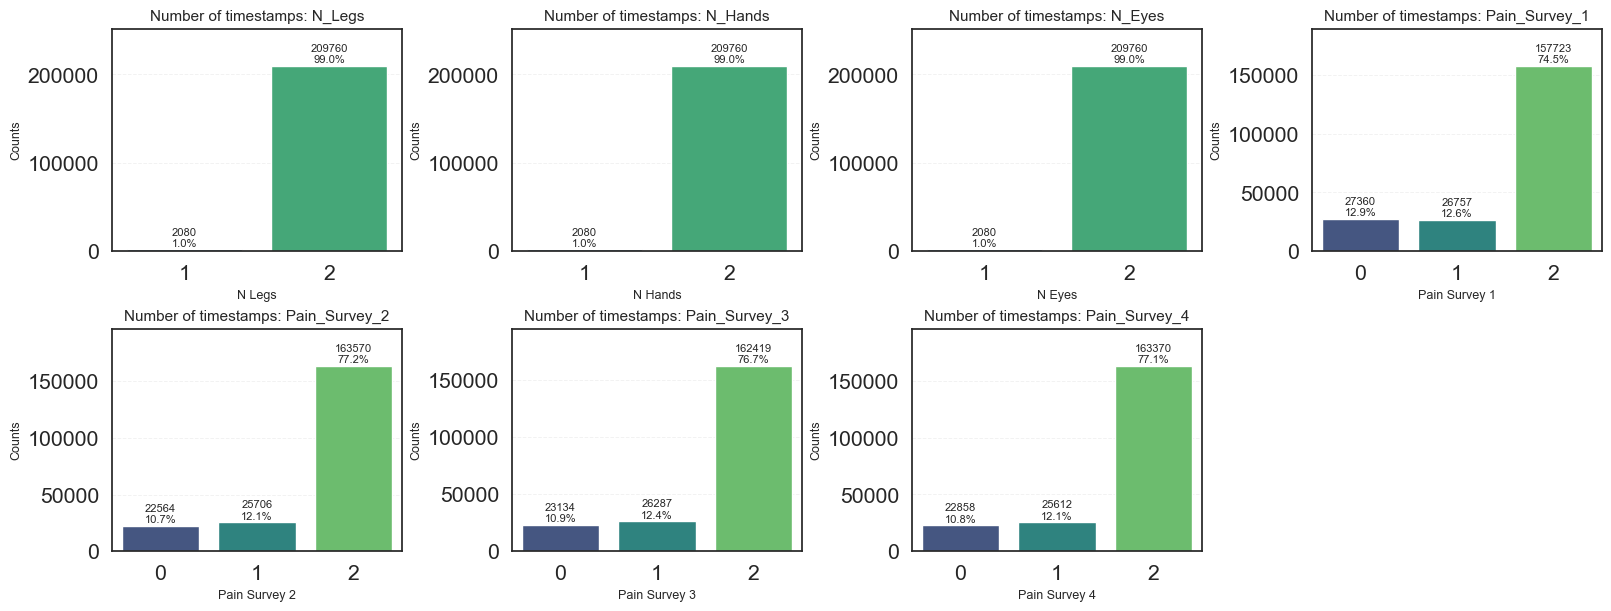

In [48]:
plot_timestamps_per_feature(kaggle_test_df, categorical_columns, n_cols=4)

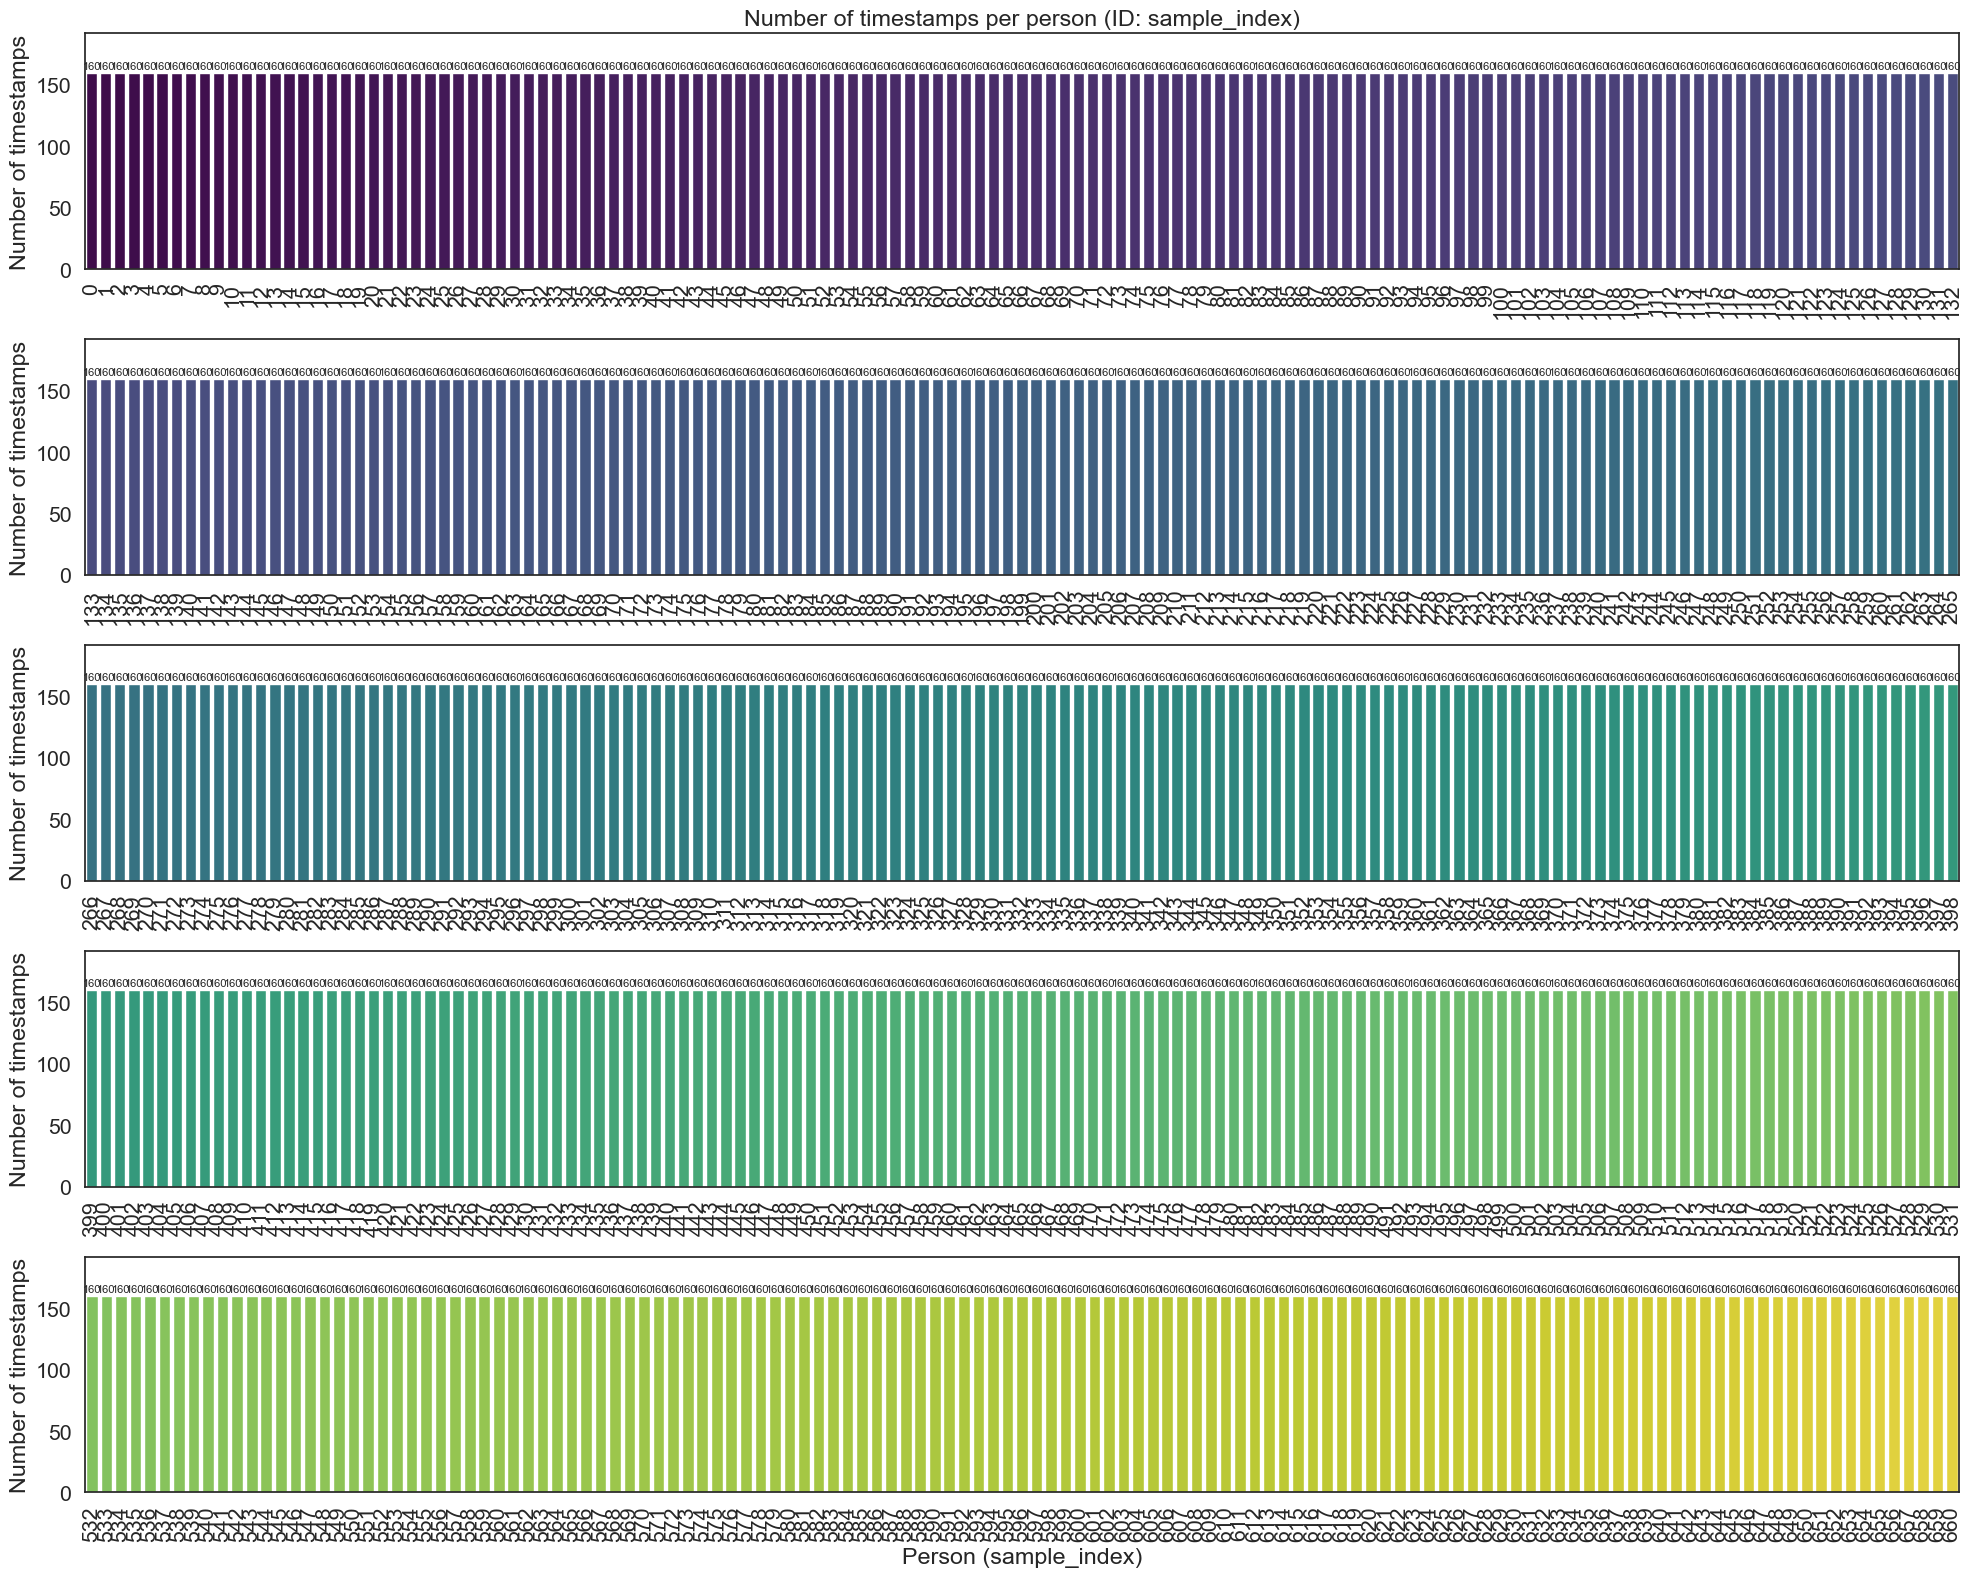

In [49]:
# Count of timestamps per person (identified by sample_index)
counts = (
    train_df.groupby('sample_index')
    .size()
    .rename('n_timestamps')
    .sort_index()
)

import math

n_people = len(counts)
n_rows = 5
chunk_size = max(1, math.ceil(n_people / n_rows))

colors = plt.cm.viridis(np.linspace(0, 1, n_people))

# Figure size: width based on the maximum block size, height for 4 rows
fig_width = max(17.0, chunk_size * 0.15)
fig_height = 16  # 4 rows
fig, axes = plt.subplots(n_rows, 1, figsize=(fig_width, fig_height), sharey=True)

# Ensure an array of axes
axes = np.atleast_1d(axes)

y_max = counts.values.max() if n_people > 0 else 0

for i in range(n_rows):
    ax = axes[i]
    start = i * chunk_size
    end = min(start + chunk_size, n_people)

    if start >= end:
        ax.axis('off')
        continue

    idx = counts.index[start:end]
    vals = counts.values[start:end]
    pal = colors[start:end]

    sns.barplot(x=list(range(len(idx))), y=vals, palette=pal, ax=ax)

    # Tick labels with the original sample_index
    ax.set_xticks(range(len(idx)))
    ax.set_xticklabels(idx)

    # Labels above the bars
    for j, v in enumerate(vals):
        ax.text(j, v + (y_max * 0.01 if y_max > 0 else 0.01), f"{int(v)}", ha="center", va="bottom", fontsize=8)

    ax.set_ylabel("Number of timestamps")
    if len(vals) > 30:
        ax.tick_params(axis='x', rotation=90)

    ax.set_ylim(0, (y_max * 1.20) if y_max > 0 else 1)

axes[0].set_title("Number of timestamps per person (ID: sample_index)")
axes[-1].set_xlabel("Person (sample_index)")

plt.tight_layout(rect=(0, 0, 1, 1))
# plt.savefig('timestamps_per_person.png', dpi=300, bbox_inches='tight')
plt.show()

In [50]:
# Inspect sensor data for a specific person
def inspect_sensor_data(s_i, df):
    # Filter the DataFrame for the specified person (sample_index)
    data = df[df['sample_index'] == s_i][['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']]

    # Plot the sensor data for each axis
    axis = data.plot(subplots=True, figsize=(18, 4), title="Sample Index: " + str(s_i))

    # Adjust legend position for each subplot
    for ax in axis:
        ax.legend(loc='lower right')

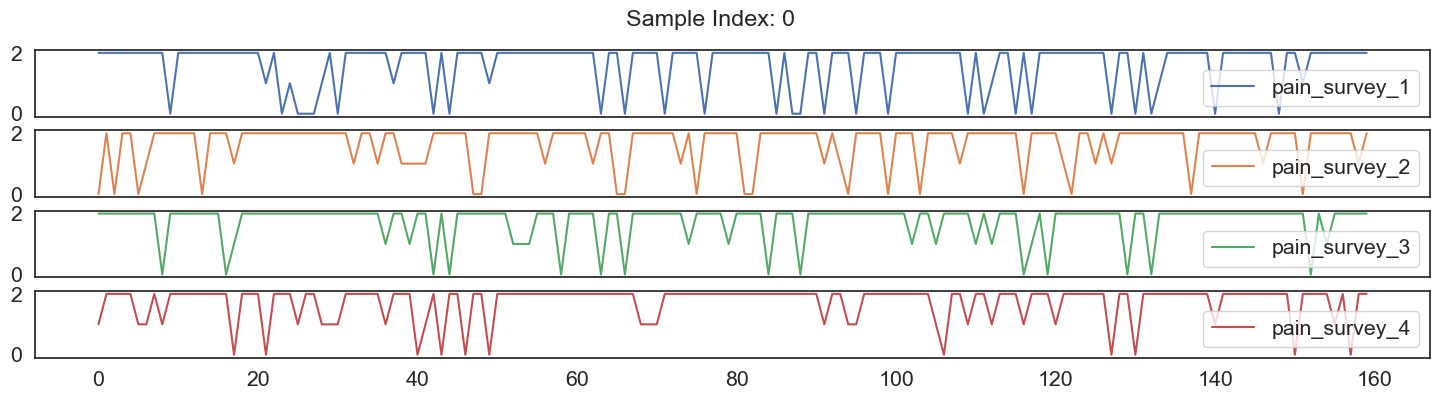

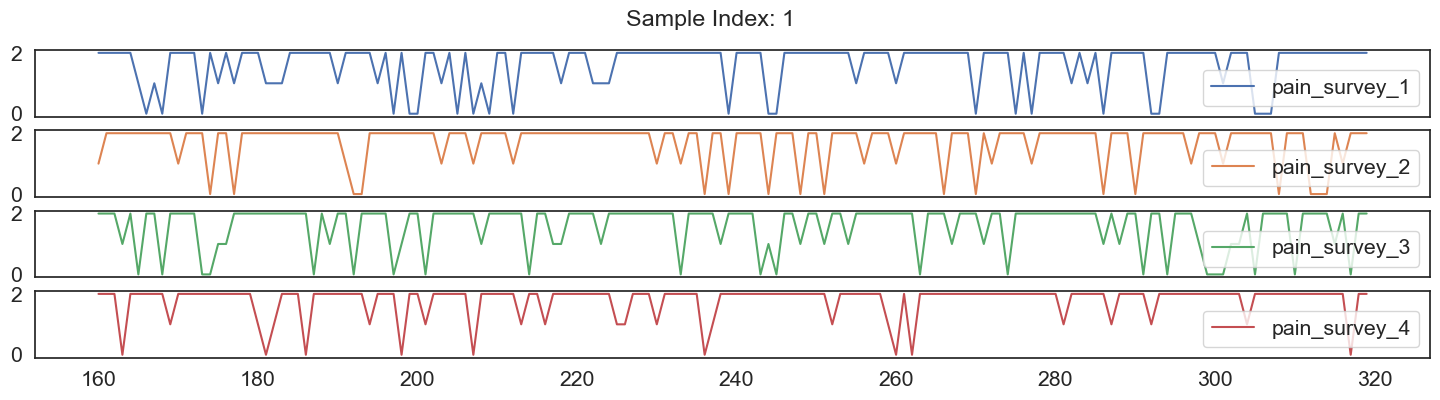

In [51]:
for sample_index in train_df['sample_index'].unique()[:2]:
    inspect_sensor_data(sample_index, train_df)

In [52]:
# Now it is time to analyze and visualize joint_00 to joint_30 data
joint_columns = [f'joint_{i:02d}' for i in range(31)]


def plot_joint_distributions(df, joint_cols, n_cols=4, figsize_per_plot=(4, 3)):
    n = len(joint_cols)
    n_rows = (n + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize_per_plot[0] * n_cols, figsize_per_plot[1] * n_rows),
                             constrained_layout=True)
    axes = axes.flatten()

    for ax, col in zip(axes, joint_cols):
        sns.histplot(
            df[col].dropna(),
            bins=30,
            kde=True,
            color='skyblue',
            ax=ax
        )
        ax.set_title(f"Distribution of {col.title()}", fontsize=11)
        ax.set_xlabel(col.replace('_', ' ').title(), fontsize=9)
        ax.set_ylabel("Frequency", fontsize=9)
        ax.grid(axis='y', alpha=0.25, linestyle='--', linewidth=0.7)

    for ax in axes[n:]:
        ax.axis('off')

    plt.show()
    plt.close(fig)

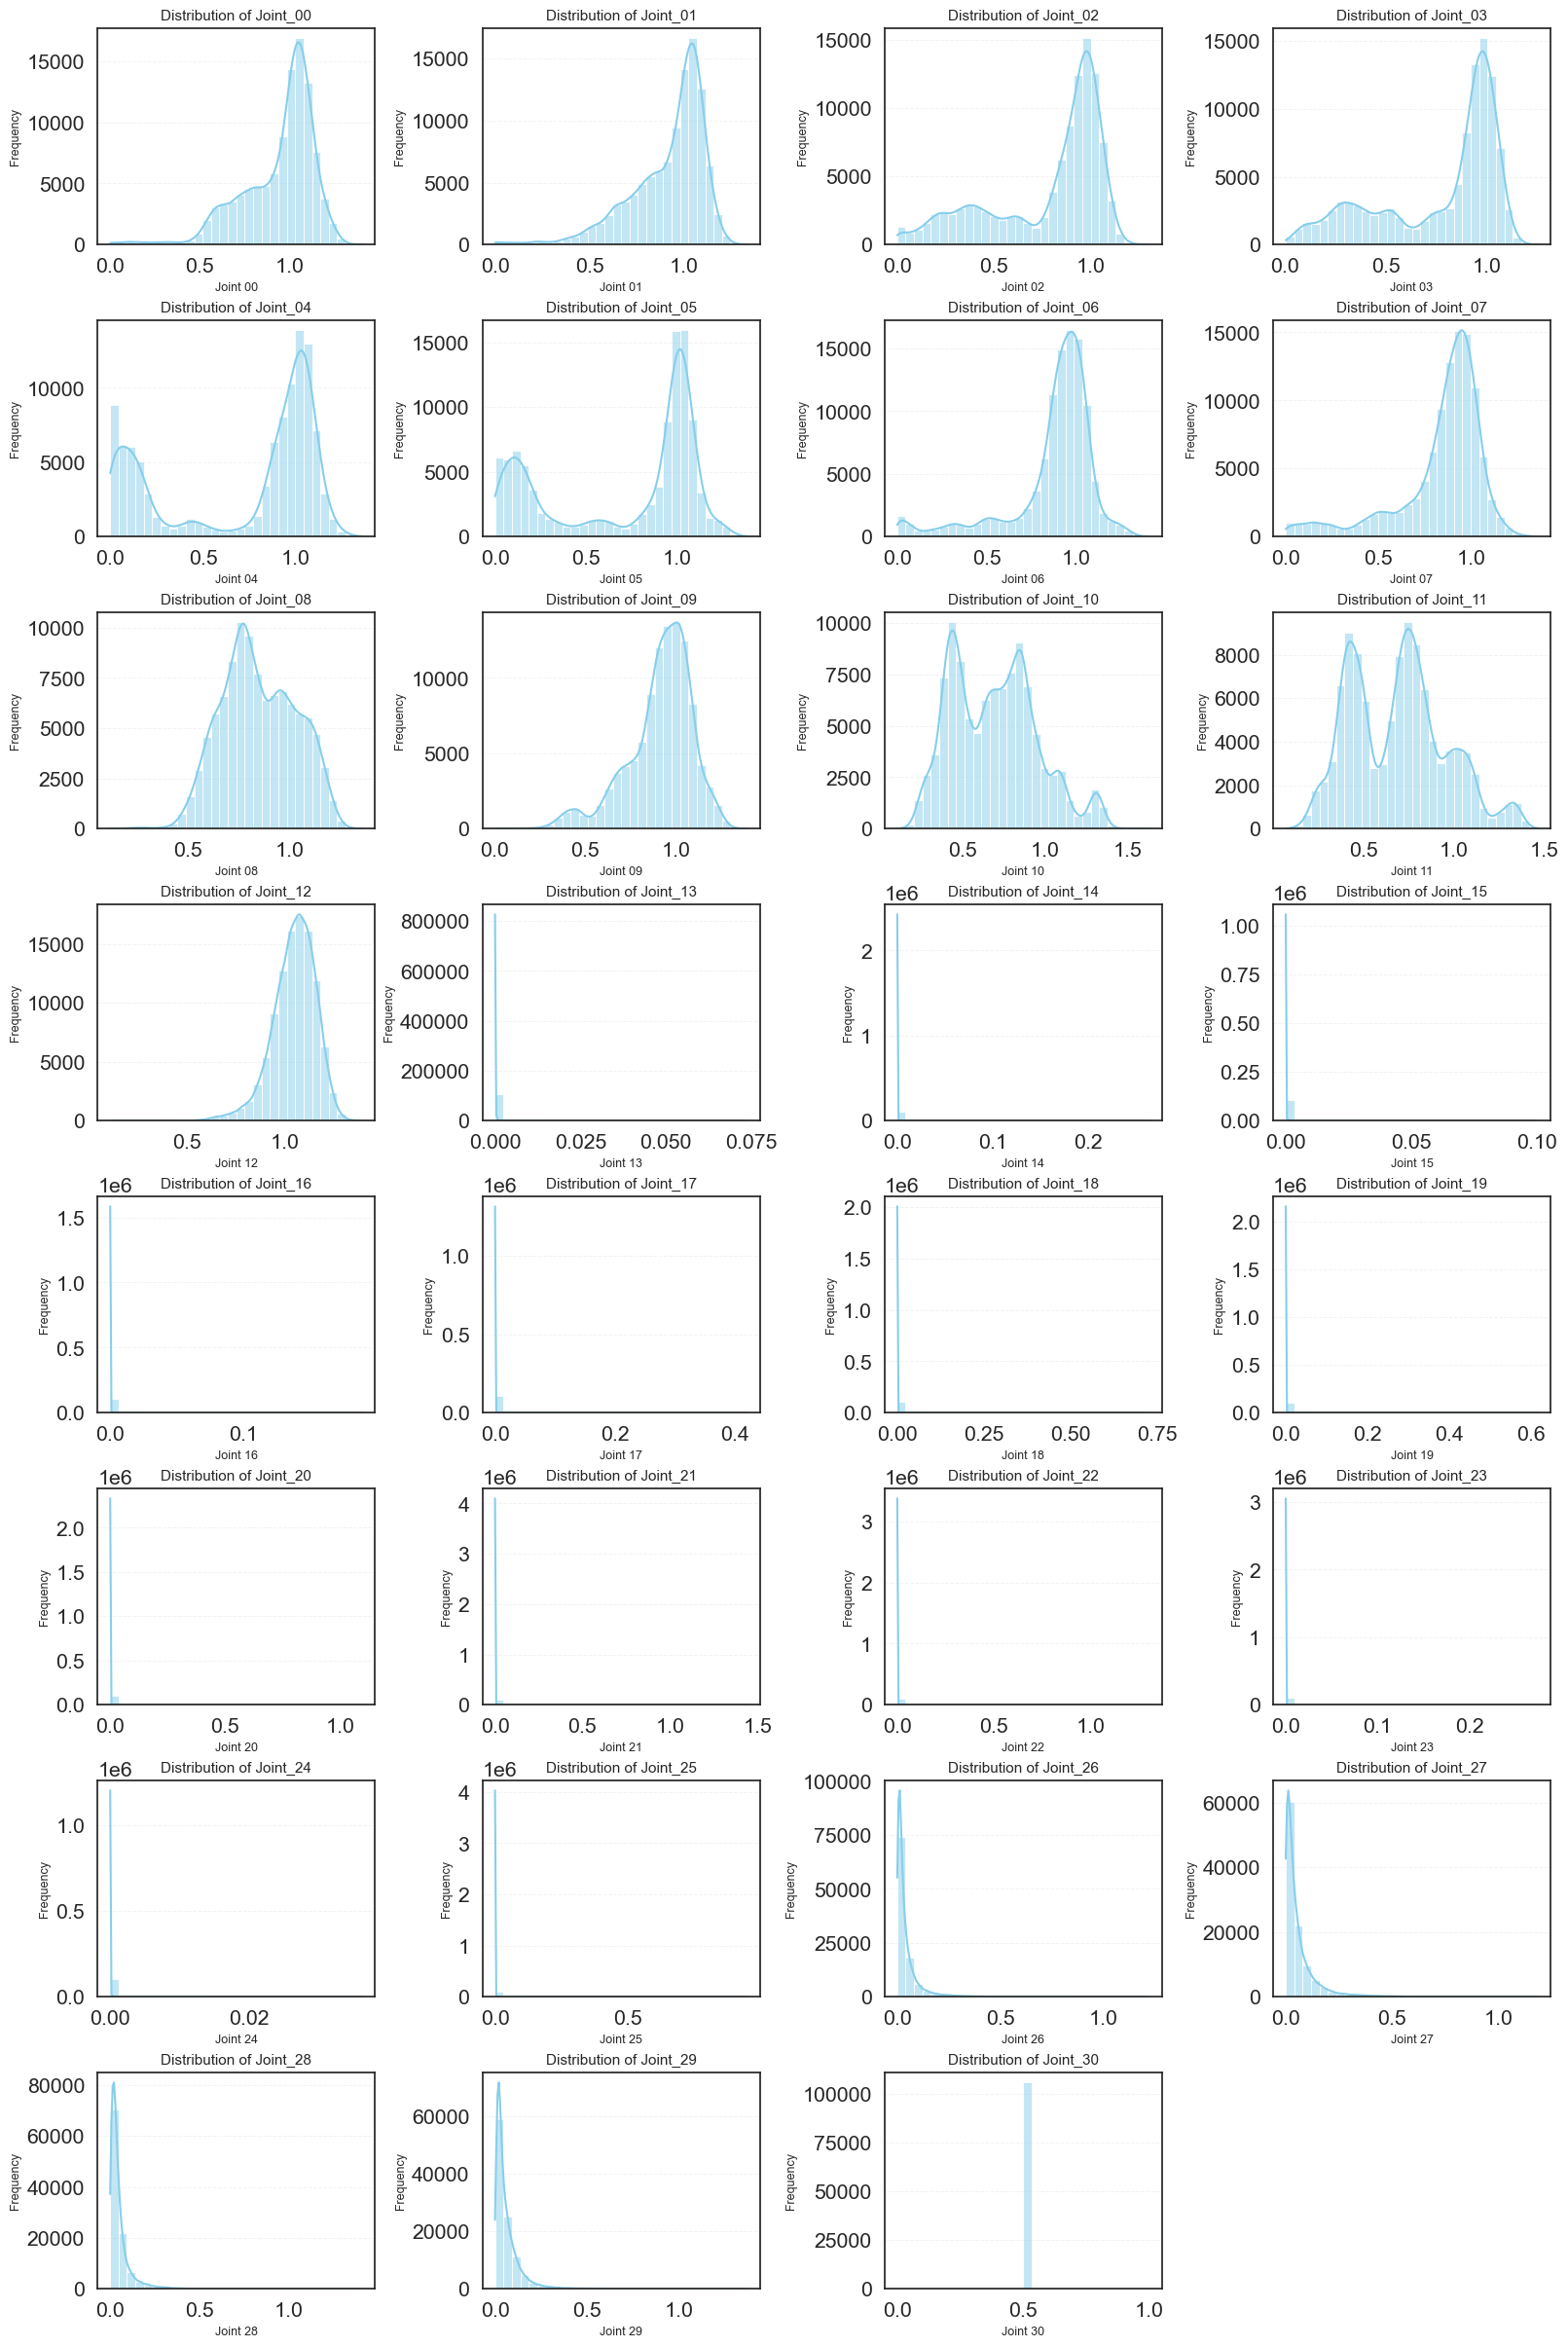

In [53]:
plot_joint_distributions(train_df, joint_columns)

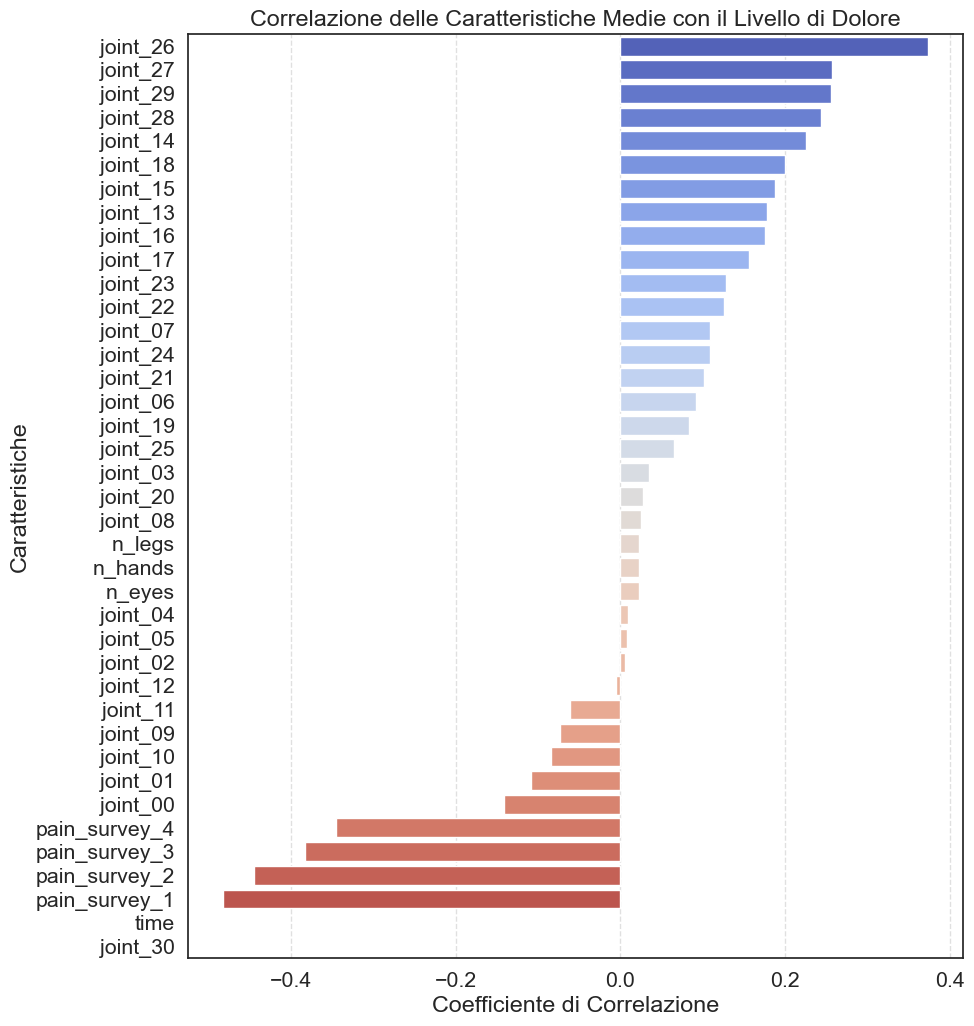

In [54]:
# Correlazione tra caratteristiche medie e livello di dolore
# Proposta da Gemini

train_full_df = pd.merge(train_df, labels_df, on='sample_index')

# Prepara i dati per la correlazione
# Crea una copia per evitare di modificare il dataframe originale
corr_df = train_full_df.copy()

# Calcola la media delle caratteristiche per ogni persona
person_avg_df = corr_df.groupby('sample_index').mean()

# Calcola la matrice di correlazione
correlation_matrix = person_avg_df.corr()

# Seleziona solo la correlazione con l'etichetta del dolore e ordinala
pain_correlation = correlation_matrix['label'].drop('label').sort_values(ascending=False)

# Visualizza la correlazione con il dolore
plt.figure(figsize=(10, 12))
sns.barplot(x=pain_correlation.values, y=pain_correlation.index, palette='coolwarm')
plt.title('Correlazione delle Caratteristiche Medie con il Livello di Dolore')
plt.xlabel('Coefficiente di Correlazione')
plt.ylabel('Caratteristiche')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [55]:
# Fatto da Gemini

def plot_feature_distribution_by_pain_level(full_df, features_to_plot):
    n_features = len(features_to_plot)

    # Crea i subplot
    fig, axes = plt.subplots(n_features, 1, figsize=(12, n_features * 4))
    fig.suptitle('Distribuzione delle Caratteristiche per Livello di Dolore', fontsize=16)

    for i, feature in enumerate(features_to_plot):
        sns.boxplot(
            x='label',
            y=feature,
            data=full_df,
            order=[0, 1, 2],
            ax=axes[i]
        )
        axes[i].set_title(f'Distribuzione di {feature}')
        axes[i].set_xlabel('Livello di Dolore')
        axes[i].set_ylabel('Valore')

    plt.tight_layout(rect=(0, 0, 1, 0.97))
    plt.show()


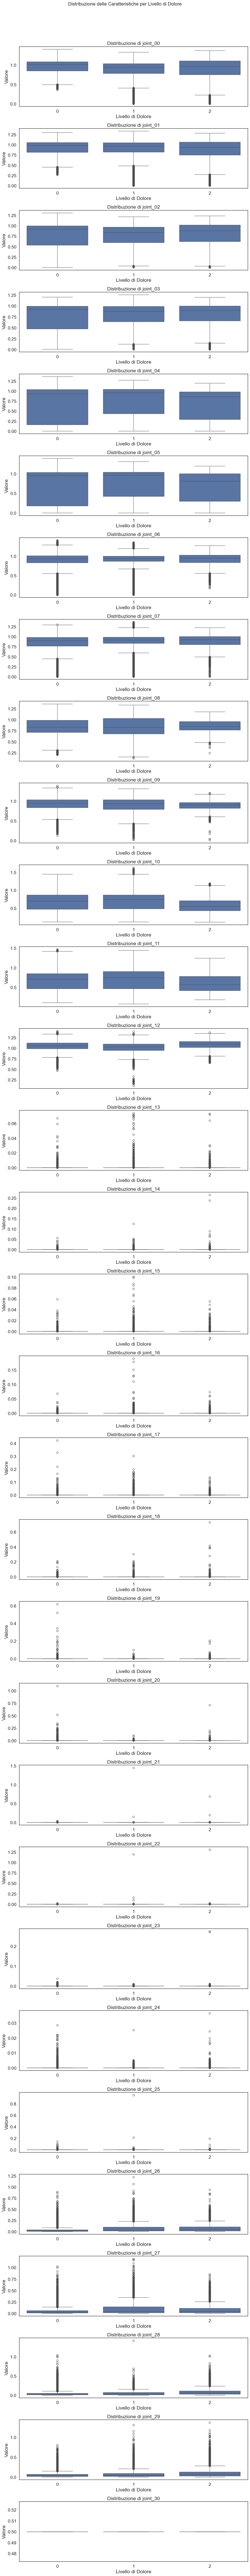

In [56]:
plot_feature_distribution_by_pain_level(train_full_df, joint_columns)

In [57]:
# Fatto da Gemini

def analyze_features_over_time_grid(features, df, n_cols=4, figsize_per_plot=(5.5, 2.8)):
    import math

    n = len(features)
    n_rows = math.ceil(n / n_cols)
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(figsize_per_plot[0] * n_cols, figsize_per_plot[1] * n_rows),
        sharex=True
    )
    axes = axes.flatten()

    # Precalcolo delle medie per ogni livello di dolore su tutte le feature
    pain_cfg = [
        (0, 'tab:green'),
        (1, 'tab:orange'),
        (2, 'tab:red'),
    ]
    means_by_pain = {}
    for pain_level, color in pain_cfg:
        mean_df = df[df['label'] == pain_level].groupby('time')[features].mean()
        means_by_pain[pain_level] = (mean_df, color)

    # Disegno per-feature
    for ax, feat in zip(axes, features):
        for pain_level, (mean_df, color) in means_by_pain.items():
            if feat in mean_df.columns:
                ax.plot(mean_df.index, mean_df[feat].values, label=pain_level, color=color, linewidth=1.2)
        ax.set_title(feat.replace('_', ' ').title(), fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.5)

    # Celle in eccesso
    for ax in axes[n:]:
        ax.axis('off')

    # Legenda condivisa
    handles = [plt.Line2D([0], [0], color=color, lw=2) for _, color in pain_cfg]
    labels = [lvl for lvl, _ in pain_cfg]
    fig.legend(handles, labels, loc='upper right', frameon=False)

    fig.suptitle('Andamento temporale medio per livello di dolore', y=0.995)
    fig.supxlabel('Tempo')
    fig.supylabel('Valore medio')

    plt.tight_layout(rect=(0, 0, 0.9, 0.96))
    plt.show()
    plt.close(fig)


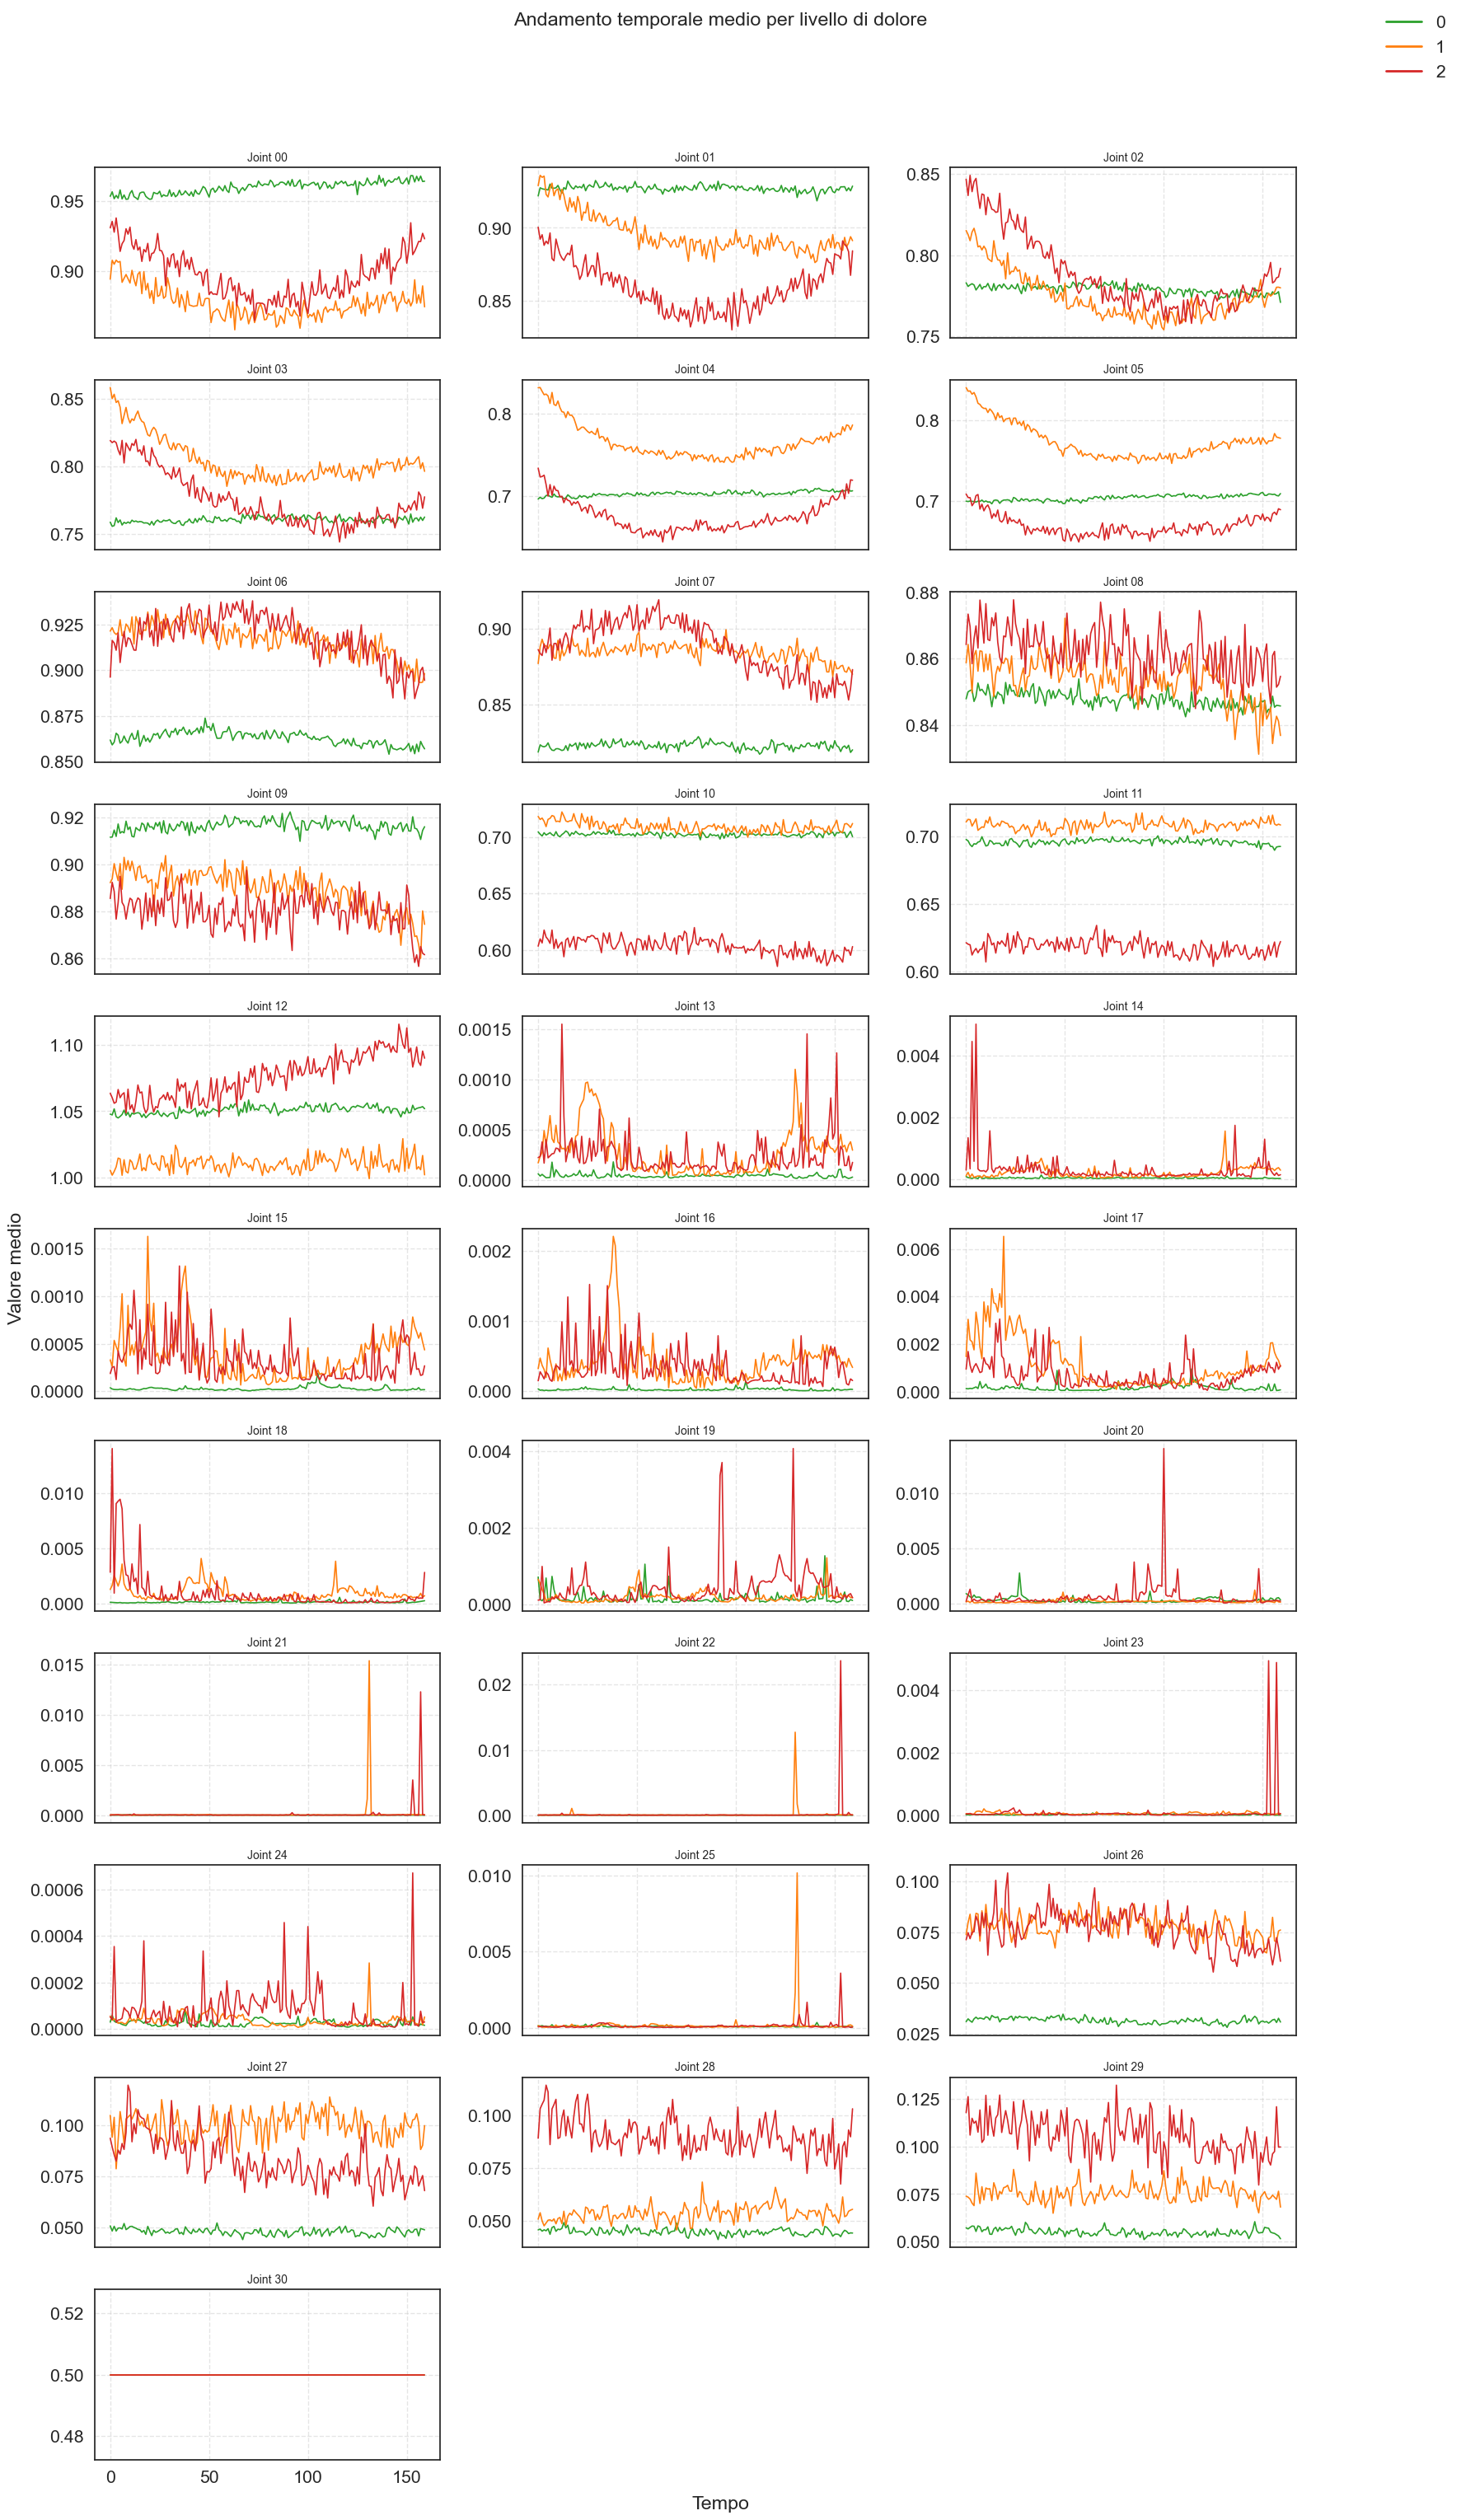

In [58]:
analyze_features_over_time_grid(joint_columns, train_full_df, n_cols=3, figsize_per_plot=(6, 2.8))